In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt

In [2]:
import scipy.io
mat = scipy.io.loadmat('../DATA/CYLINDER_ALL.mat',)
nx = 449
ny = 199
dt = .2

In [3]:
xx, yy = np.meshgrid(np.linspace(-1, 8, nx), np.linspace(-2, 2, ny))

def cylinder_clean_data(X, fill = 0):
    
    uu = X.reshape((ny, nx, -1), order = 'F')
    uu[(xx**2+yy**2)<.5**2, :] = fill
    
    return uu.reshape((ny*nx, -1), order = 'F')

def reshaping(X):
    
    return X.reshape((ny, nx), order = 'F')

cylinder_idx = (xx**2+yy**2)<.5**2

## X Velocity reduction

In [4]:
X = cylinder_clean_data(mat["UALL"])

In [5]:
pod = ROM(rom="pod")
pod.decompose(X, alg="snap",)

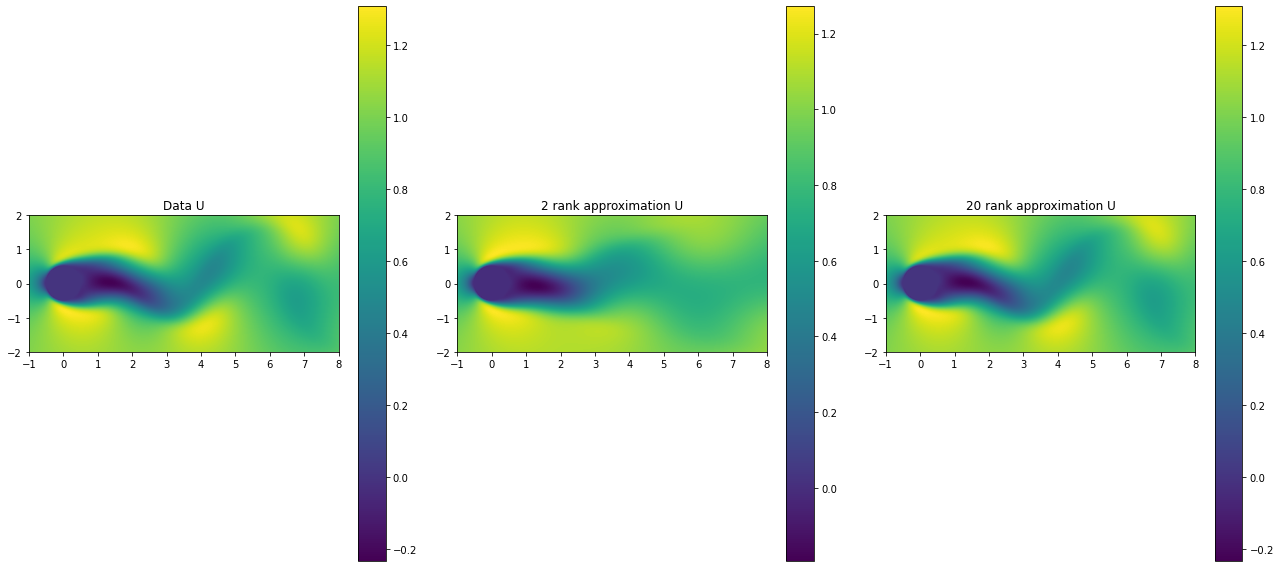

In [6]:
rank1 = 2
rank2 = 20
instant  = 0


fig, ax  = plt.subplots(1, 3, figsize = (18, 8))
im = ax[0].imshow(reshaping(X[:, instant]), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[0]);
ax[0].set_title("Data U");

im = ax[1].imshow(reshaping(pod.approximate(rank1)[:, instant]), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[1]);
ax[1].set_title("{} rank approximation U" .format(rank1));

im = ax[2].imshow(reshaping(pod.approximate(rank2)[:, instant]), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[2]);
ax[2].set_title("{} rank approximation U" .format(rank2));

fig.tight_layout();

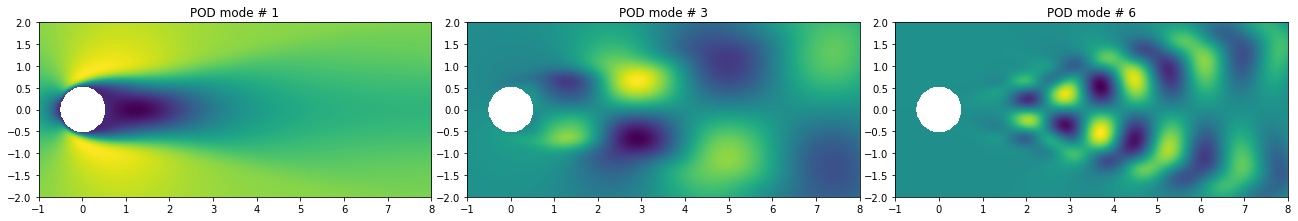

In [7]:
n_mode = [0, 2, 5]

fig, ax  = plt.subplots(1, 3, figsize = (18, 8))

for i in range(len(n_mode)):
    
    modes = cylinder_clean_data(pod.modes[:, n_mode[i]].copy(), np.nan)
    im = ax[i].imshow(reshaping(modes), extent=[-1, 8, -2, 2]);
    ax[i].set_title("POD mode # {}" .format(n_mode[i]+1));

fig.tight_layout();

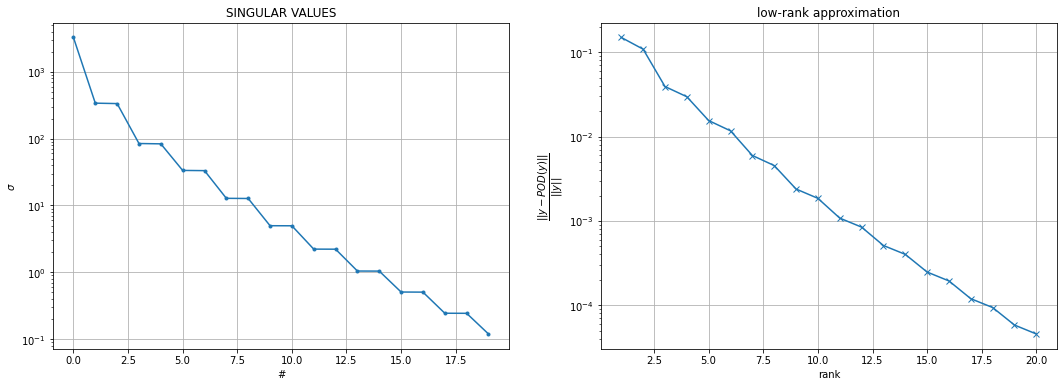

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
y = np.zeros(20)
ranks = np.arange(20)+1
for i in range(20):
    y[i] = np.linalg.norm(X - pod.approximate(i+1))/np.linalg.norm(X)

    
ax[0].semilogy(pod.singvals[:20], '.-')
ax[0].grid();
ax[0].set_ylabel("$\sigma$")
ax[0].set_xlabel("#");
ax[0].set_title("SINGULAR VALUES");

ax[1].semilogy(ranks, y, 'x-')
ax[1].grid();
ax[1].set_ylabel("$\dfrac{||y - POD(y)||}{||y||}$")
ax[1].set_xlabel("rank");
ax[1].set_title("low-rank approximation");

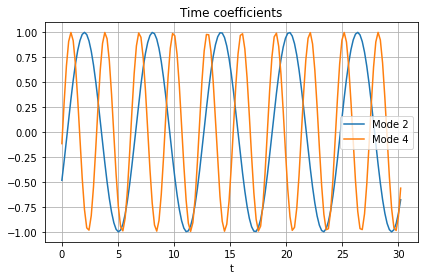

In [9]:
t = np.linspace(0, X.shape[1] * dt, X.shape[1])
fig = plt.figure()

plt.plot(t, pod.time[1, :]/pod.time[1, :].max(), label = "Mode 2")
plt.plot(t, pod.time[3, :]/pod.time[3, :].max(), label = "Mode 4")

plt.grid();
plt.title("Time coefficients");
plt.xlabel("t");
plt.legend(loc = "best");
plt.tight_layout();

## CPU Time (SVD vs Snapshot)

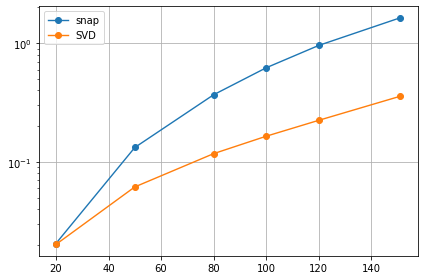

In [10]:
import time
cov_times = []
svd_times = []
sizes = [20, 50, 80, 100, 120, 151]
nt = 5

for s in  sizes:
    t0 = time.time()
    for _ in range (nt):
        pod = ROM(rom="pod")
        pod.decompose(X[:, :s], alg="snap",)
    t1 = time.time()
    cov_times.append((t1 - t0)/nt)

    t0 = time.time()
    for _ in range (nt):
        pod = ROM(rom="pod")
        pod.decompose(X[:, :s], alg="svd",)
    t1 = time.time()
    svd_times.append((t1 - t0)/nt)

plt.semilogy(sizes, cov_times, "o-", label = "snap", linewidth = 1.4);
plt.semilogy(sizes, svd_times, "o-", label = "SVD", linewidth = 1.4);
plt.grid();
plt.legend();
plt.tight_layout();

## Vector Velocity reduction

In [11]:
## -------------- POD on X AND Y velocity components --------------
Y = cylinder_clean_data(mat["VALL"])
vector = np.vstack((X, Y))
pod_vector = ROM(rom="pod")
pod_vector.decompose(vector, alg="svd",)

Augmenting Data to X and Y velocity components, approximate by a lower rank reconstruction

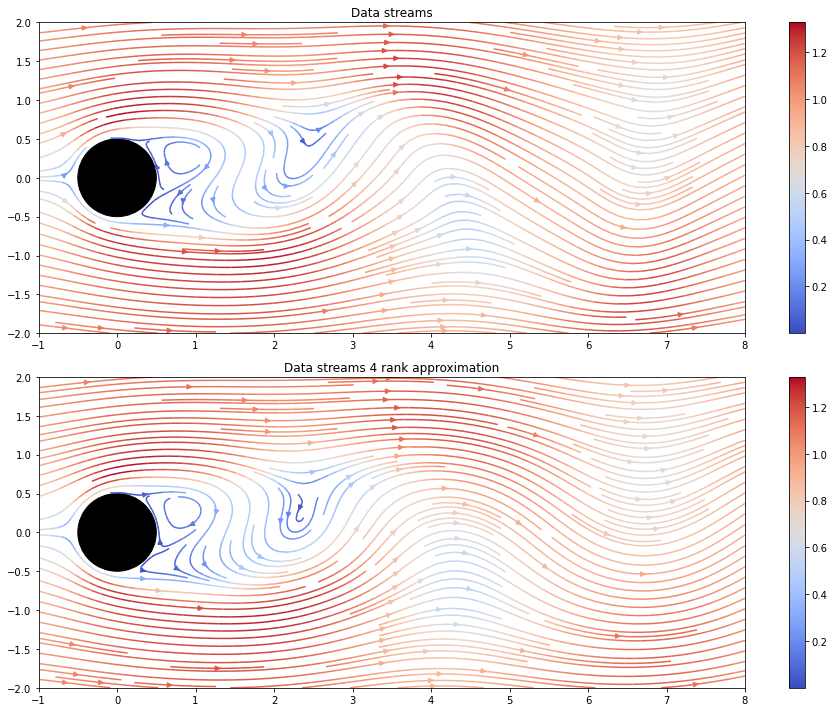

In [12]:
from matplotlib.patches import Circle
rank = 3
instant= -1


fig, ax  = plt.subplots(2, 1, figsize = (13, 10))

uu = reshaping(cylinder_clean_data(X[:, instant], np.nan))
vv = reshaping(cylinder_clean_data(Y[:, instant], np.nan))

strm = ax[0].streamplot(xx, yy, uu, vv, color = np.sqrt(uu**2+vv**2), density = 2, cmap = 'coolwarm')
ax[0].set_title("Data streams");
fig.colorbar(strm.lines, ax = ax[0])
ax[0].add_artist(Circle((0, 0), .5, color = "#000000"), )


low_uu = reshaping(cylinder_clean_data(pod_vector.approximate(rank)[:(nx*ny), instant], np.nan))
low_vv = reshaping(cylinder_clean_data(pod_vector.approximate(rank)[(nx*ny)::, instant], np.nan))

strm = ax[1].streamplot(xx, yy, low_uu, low_vv, color = np.sqrt(low_uu**2+low_vv**2), density = 2, cmap = 'coolwarm')
ax[1].set_title("Data streams {} rank approximation".format(rank+1));
ax[1].add_artist(Circle((0, 0), .5, color = "#000000"), )
fig.colorbar(strm.lines, ax = ax[1])

fig.tight_layout();

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

DMD reduction on X components velocity

In [13]:
## Parameters ----------------
rank = 21
dt = .2
X = np.nan_to_num(cylinder_clean_data(mat["UALL"]), 0) # X-Velocity
t = np.linspace(0, (X.shape[1]-1) * dt, X.shape[1])

In [14]:
dmd = ROM("dmd")
dmd.decompose(X[:, :-1], X[:, 1::], dt = dt, rank = rank, sorting="real")

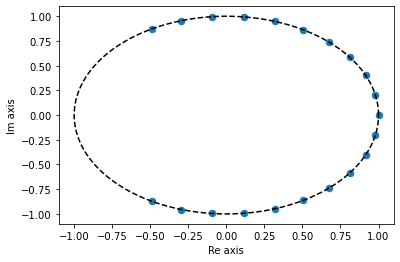

In [15]:
plt.plot(np.real(dmd.lambd), np.imag(dmd.lambd), '.', markersize = 13,);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

## Reconstructing X
Reconstruct data using dmd on the first 151 instants

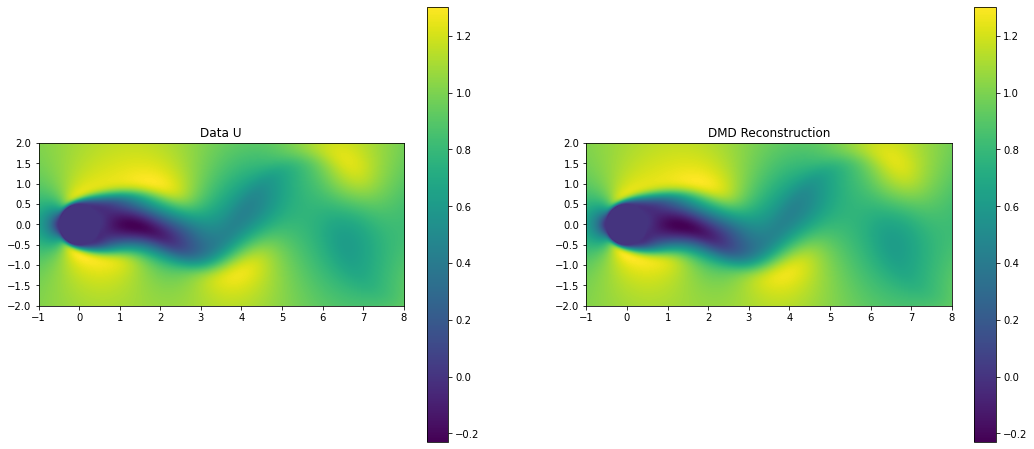

In [16]:
predicted_X = np.real(dmd.dmd_predict(t, X[:, 0]))

fig, ax  = plt.subplots(1, 2, figsize = (18, 8))
im = ax[0].imshow(X[:, -1].reshape((ny, nx), order = 'F'), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[0]);
ax[0].set_title("Data U");

im = ax[1].imshow(predicted_X[:, -1].reshape((ny, nx), order = 'F'), extent=[-1, 8, -2, 2]);
fig.colorbar(im, ax=ax[1]);
ax[1].set_title("DMD Reconstruction");

**Spatial Modes**

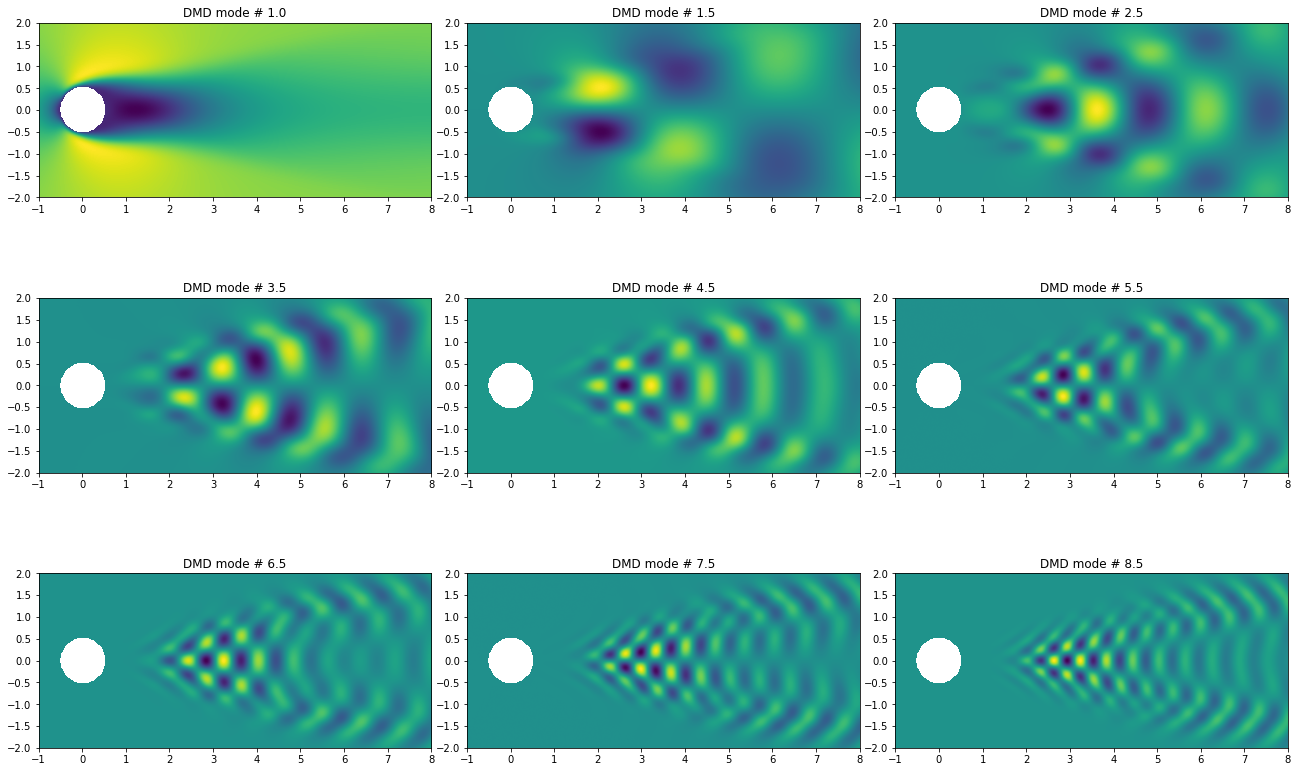

In [17]:
n_mode = np.concatenate((np.array([0]), np.arange(1, 19, 2)))

fig, ax  = plt.subplots(3, 3, figsize = (18, 12))

for i in range(3):
    for j in range(3):
        
        to_plot = np.real(reshaping(dmd.dmd_modes[:, n_mode[((i)*3)+j]].copy()))
        to_plot[cylinder_idx] = np.nan
        im = ax[i, j].imshow(to_plot, extent=[-1, 8, -2, 2]);
        ax[i, j].set_title("DMD mode # {}" .format((n_mode[((i)*3)+j]+2)/2));


fig.tight_layout();

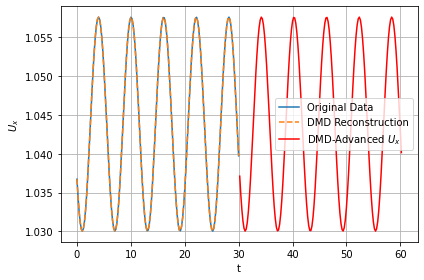

In [18]:
adv_t = np.linspace(0, (2 * X.shape[1]-1) * dt, 2*X.shape[1])
advance_X = dmd.dmd_predict(adv_t, X[:, 0])

plt.plot(t, X[4000, :], label="Original Data");
plt.plot(adv_t[:X.shape[1]], np.real(advance_X[4000, :X.shape[1]]), '--', label = "DMD Reconstruction");
plt.plot(adv_t[X.shape[1]::], np.real(advance_X[4000, X.shape[1]::]), 'r-', label = "DMD-Advanced $U_x$");
plt.xlabel("t");
plt.ylabel("$U_x$");
plt.legend(loc = "best");
plt.grid();
plt.tight_layout();
